# 0D 热控制系统仿真与控制策略评价

## 概述

本 Notebook 实现零维（集总参数）房间温度控制仿真，包含：

1. **实验一**：Bang-Bang 控制器的 Zeno Effect 展示
2. **实验二**：6 种控制策略（Bang-Bang、Hysteresis、P、PI、PID、LQR）的性能对比与统一代价评价

### 0D 模型

$$\frac{dT}{dt} = -k(T - T_a) + u(t)$$

其中 $u(t) \in [0, U_{\max}]$ 为控制输入（加热功率）。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are
import warnings
warnings.filterwarnings('ignore')

# 输出目录
import os
OUT_DIR = '0D_output'
os.makedirs(OUT_DIR, exist_ok=True)

# 全局绘图风格
sns.set_style('whitegrid')
plt.rcParams.update({
    'figure.dpi': 150,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
    'legend.fontsize': 9,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.bbox': 'tight',
    'savefig.dpi': 300,
})

# 策略配色方案
STRATEGY_COLORS = {
    'Bang-Bang': '#e74c3c',
    'Hysteresis': '#e67e22',
    'P': '#2ecc71',
    'PI': '#3498db',
    'PID': '#9b59b6',
    'LQR': '#1abc9c',
}

print('所有库导入成功。')

所有库导入成功。


## 参数定义与 ODE 求解器

固定参数：
- $T_a = 5°C$（环境温度）
- $T_{set} = 20°C$（设定温度）
- $T_{init} = 15°C$（初始温度）
- $k = 0.1\,\text{min}^{-1}$（散热系数）
- $U_{max} = 2.5\,°C/\text{min}$（最大加热功率）
- $t_{end} = 60\,\text{min}$（仿真时长）

In [2]:
# ============================================================
# 系统参数
# ============================================================
T_a = 5.0        # 环境温度 (°C)
T_set = 20.0     # 设定温度 (°C)
T_init = 15.0    # 初始温度 (°C)
k = 0.1          # 散热系数 (min^{-1})
U_max = 2.5      # 最大加热功率 (°C/min)
t_end = 60.0     # 仿真时长 (min)

# 稳态温度与功率
T_ss_heat = T_a + U_max / k  # 全功率加热稳态 = 30°C
T_ss_cool = T_a              # 关闭加热稳态 = 5°C
u_ss = k * (T_set - T_a)     # 维持 T_set 所需的稳态功率

print(f'稳态加热功率 u_ss = {u_ss:.2f} °C/min')
print(f'全功率加热稳态温度 = {T_ss_heat:.0f}°C')
print(f'U_max = {U_max:.2f} °C/min  →  u_ss/U_max = {u_ss/U_max:.1%}')

稳态加热功率 u_ss = 1.50 °C/min
全功率加热稳态温度 = 30°C
U_max = 2.50 °C/min  →  u_ss/U_max = 60.0%


In [3]:
# ============================================================
# 离散时间仿真器（Euler 法，支持所有控制策略）
# ============================================================

def simulate_0d(controller, dt=0.001, t_end=60.0, T_init=15.0,
                T_a=5.0, k=0.1, U_max=2.5, T_set=20.0):
    """
    使用 Euler 法仿真 0D 热模型。
    
    参数:
        controller: 控制器函数 (t, T, state) -> (u, state)
        dt: 时间步长 (min)
        其余为物理参数
    
    返回:
        t_arr, T_arr, u_arr
    """
    n_steps = int(t_end / dt)
    t_arr = np.linspace(0, t_end, n_steps + 1)
    T_arr = np.zeros(n_steps + 1)
    u_arr = np.zeros(n_steps + 1)
    T_arr[0] = T_init
    
    state = {'integral': 0.0, 'prev_error': T_set - T_init, 'heater_on': True}
    
    for i in range(n_steps):
        u, state = controller(t_arr[i], T_arr[i], state)
        u = np.clip(u, 0, U_max)
        u_arr[i] = u
        dTdt = -k * (T_arr[i] - T_a) + u
        T_arr[i+1] = T_arr[i] + dTdt * dt
    
    u_last, _ = controller(t_arr[-1], T_arr[-1], state)
    u_arr[-1] = np.clip(u_last, 0, U_max)
    
    return t_arr, T_arr, u_arr

print('仿真器定义完成。')

仿真器定义完成。


In [4]:
# ============================================================
# 6 种控制策略定义
# ============================================================

def make_bangbang(T_set=20.0, U_max=2.5):
    """Bang-Bang 控制器"""
    def controller(t, T, state):
        u = U_max if T < T_set else 0.0
        return u, state
    return controller

def make_hysteresis(T_set=20.0, U_max=2.5, delta=0.5):
    """迟滞控制器（Hysteresis）"""
    def controller(t, T, state):
        if state['heater_on']:
            if T >= T_set + delta:
                state['heater_on'] = False
        else:
            if T <= T_set - delta:
                state['heater_on'] = True
        u = U_max if state['heater_on'] else 0.0
        return u, state
    return controller

def make_P(T_set=20.0, U_max=2.5, Kp=2.0):
    """比例控制器（P）"""
    def controller(t, T, state):
        e = T_set - T
        u = Kp * e
        return u, state
    return controller

def make_PI(T_set=20.0, U_max=2.5, Kp=2.0, Ki=0.5, dt=0.001):
    """比例-积分控制器（PI）"""
    def controller(t, T, state):
        e = T_set - T
        state['integral'] += e * dt
        u = Kp * e + Ki * state['integral']
        return u, state
    return controller

def make_PID(T_set=20.0, U_max=2.5, Kp=2.0, Ki=0.5, Kd=1.0, dt=0.001):
    """比例-积分-微分控制器（PID）"""
    def controller(t, T, state):
        e = T_set - T
        state['integral'] += e * dt
        de = (e - state['prev_error']) / dt if dt > 0 else 0.0
        state['prev_error'] = e
        u = Kp * e + Ki * state['integral'] + Kd * de
        return u, state
    return controller

def make_LQR(T_set=20.0, T_a=5.0, U_max=2.5, k=0.1, Q=100.0, R_lqr=0.1):
    """
    LQR 控制器。
    线性化：dx/dt = A*x + B*v, x = T - T_set, v = u - u_ss
    A = -k, B = 1
    """
    A = np.array([[-k]])
    B = np.array([[1.0]])
    Q_mat = np.array([[Q]])
    R_mat = np.array([[R_lqr]])
    P = solve_continuous_are(A, B, Q_mat, R_mat)
    K_gain = (1.0 / R_lqr) * (B.T @ P)[0, 0]
    u_ss_val = k * (T_set - T_a)
    print(f'  LQR 增益 K = {K_gain:.4f}, 稳态输入 u_ss = {u_ss_val:.2f}')
    
    def controller(t, T, state):
        x = T - T_set
        v = -K_gain * x
        u = v + u_ss_val
        return u, state
    return controller

print('6 种控制策略定义完成。')

6 种控制策略定义完成。


In [5]:
# ============================================================
# 评价指标计算（含 Comfort Ratio）
# ============================================================

# 舒适区间定义
T_COMFORT_LOW = 18.0   # 舒适区间下限 (°C)
T_COMFORT_HIGH = 26.0  # 舒适区间上限 (°C)

def compute_metrics(t_arr, T_arr, u_arr, T_set=20.0, t_end=60.0, U_max=2.5, tol=0.5):
    """
    计算 6 个评价指标（含 Comfort Ratio）。
    返回 dict: {E, RMSE, DeltaT_max, CR, t_s, N_sw}
    """
    dt_arr = np.diff(t_arr)
    
    # 1. 能耗 E = ∫u(t)dt
    E = np.sum(u_arr[:-1] * dt_arr)
    
    # 2. 温度偏差 RMSE
    error_sq = (T_arr[:-1] - T_set) ** 2
    RMSE = np.sqrt(np.sum(error_sq * dt_arr) / t_end)
    
    # 3. 最大超调（只看正超调）
    overshoot = np.max(T_arr - T_set)
    DeltaT_max = max(0.0, overshoot)
    
    # 4. 舒适覆盖率 CR = 温度在 [18, 26] 内的时间占比
    in_comfort = ((T_arr[:-1] >= T_COMFORT_LOW) & (T_arr[:-1] <= T_COMFORT_HIGH)).astype(float)
    CR = np.sum(in_comfort * dt_arr) / t_end
    
    # 5. 稳定时间：首次进入 ±tol 且此后保持
    in_band = np.abs(T_arr - T_set) <= tol
    t_s = t_end
    for i in range(len(in_band)):
        if np.all(in_band[i:]):
            t_s = t_arr[i]
            break
    
    # 6. 切换次数
    on_off = (u_arr > 0.01 * U_max).astype(int)
    N_sw = int(np.sum(np.abs(np.diff(on_off))))
    
    return {'E': E, 'RMSE': RMSE, 'DeltaT_max': DeltaT_max, 'CR': CR, 't_s': t_s, 'N_sw': N_sw}


def compute_unified_cost(metrics, ref_maxes, weights=None, t_end=60.0):
    """
    统一代价 J = w_E*Ê + w_R*R̂MSE + w_O*ΔT̂ + w_C*(1-CR) + w_S*N̂sw + w_T*t̂s
    
    CR 用 (1-CR) 转化为"越低越好"，无需额外归一化。
    其余指标除以同批次最大值归一化。
    """
    if weights is None:
        weights = {'w_E': 0.15, 'w_R': 0.25, 'w_O': 0.15, 'w_C': 0.15, 'w_S': 0.15, 'w_T': 0.15}
    
    E_hat    = metrics['E']          / ref_maxes['E']          if ref_maxes['E'] > 0 else 0
    RMSE_hat = metrics['RMSE']       / ref_maxes['RMSE']       if ref_maxes['RMSE'] > 0 else 0
    DT_hat   = metrics['DeltaT_max'] / ref_maxes['DeltaT_max'] if ref_maxes['DeltaT_max'] > 0 else 0
    CR_cost  = 1.0 - metrics['CR']   # CR 越高越好 → (1-CR) 越低越好
    Nsw_hat  = metrics['N_sw']       / ref_maxes['N_sw']       if ref_maxes['N_sw'] > 0 else 0
    ts_hat   = min(metrics['t_s'], t_end) / t_end
    
    J = (weights['w_E'] * E_hat +
         weights['w_R'] * RMSE_hat +
         weights['w_O'] * DT_hat +
         weights['w_C'] * CR_cost +
         weights['w_S'] * Nsw_hat +
         weights['w_T'] * ts_hat)
    return J

print(f'评价指标函数定义完成。舒适区间: [{T_COMFORT_LOW}, {T_COMFORT_HIGH}]°C')

评价指标函数定义完成。舒适区间: [18.0, 26.0]°C


---

# 实验一：Bang-Bang 控制与 Zeno Effect

## 背景

理想 Bang-Bang 控制器在温度到达 $T_{set}$ 时切换状态。在连续时间极限下，温度在设定值附近无限频繁切换（**Zeno 现象**）——切换间隔 $\Delta t_n \to 0$。

本实验通过以下方式验证和可视化 Zeno Effect：
- 展示温度轨迹中 $T_{set}$ 附近的 chattering 振荡
- 控制信号的高频开关行为（放大到切换区域）
- 解析计算切换间隔 $\Delta t_n$ 的递减趋势
- 不同采样周期 $\tau$ 下切换次数的标度关系

In [6]:
# ============================================================
# 实验一：Bang-Bang 仿真 + 解析 Zeno 分析
# ============================================================

# --- 离散仿真（用于图 a, b）---
dt_fine = 0.001
ctrl_bb = make_bangbang(T_set=T_set, U_max=U_max)
t_bb, T_bb, u_bb = simulate_0d(ctrl_bb, dt=dt_fine, t_end=t_end)

# 检测切换时刻
on_off_bb = (u_bb > 0.01 * U_max).astype(int)
switch_indices = np.where(np.abs(np.diff(on_off_bb)) > 0)[0]
switch_times = t_bb[switch_indices]
switch_intervals = np.diff(switch_times)

print(f'离散仿真完成 (dt={dt_fine} min)')
print(f'总切换次数: {len(switch_times)}')

# --- 解析计算 Zeno 切换间隔 ---
# 加热段：dT/dt = -k(T-T_a) + U_max，稳态 T_h = T_a + U_max/k = 30°C
# 冷却段：dT/dt = -k(T-T_a)，稳态 T_c = T_a = 5°C
# 
# 从 T_set 开始加热，到 T_set + ε 关闭；
# 从 T_set + ε 冷却回 T_set 开启。
# 在极小振幅下，加热时间 ≈ ε / (U_max - k*(T_set - T_a))
#                      冷却时间 ≈ ε / (k*(T_set - T_a))
#
# 但对纯 Bang-Bang（无迟滞），在连续时间下 ε→0，周期→0。
# 在离散仿真中，最小 ε ≈ dT/dt * dt，所以周期 ∝ dt。
#
# 为展示间隔的衰减趋势，我们解析计算不同 ε 下的切换半周期：

T_h = T_a + U_max / k   # 30°C
T_c = T_a                # 5°C

def analytic_heating_time(T_start, T_target):
    """从 T_start 加热到 T_target 的时间（精确解）"""
    if T_start >= T_target:
        return 0.0
    return -np.log((T_target - T_h) / (T_start - T_h)) / k

def analytic_cooling_time(T_start, T_target):
    """从 T_start 冷却到 T_target 的时间（精确解）"""
    if T_start <= T_target:
        return 0.0
    return -np.log((T_target - T_c) / (T_start - T_c)) / k

# 模拟 Zeno 过程：从 T_init 加热到 T_set，然后反复切换
# 第一次加热
t_first = analytic_heating_time(T_init, T_set)
print(f'\n首次到达 T_set 的时间: {t_first:.4f} min')

# 在 T_set 处，加热一个 dt 后温度变化：
# dT = (-k*(T_set - T_a) + U_max) * dt = (U_max - u_ss) * dt
# 这个 overshoot 就是 ε
# 然后冷却回 T_set 所需时间：-ln((T_set - T_c)/(T_set+ε - T_c))/k ≈ ε/(k*(T_set-T_c))/... 

# 逐步模拟：假设初始振幅 ε_0，之后在解析框架下递推
# 实际上纯 Bang-Bang 在连续时间中不存在稳定的极限环——
# 每次 overshoot 取决于采样精度。
# 
# 更好的方式：对不同采样 dt 值，计算首次到达 T_set 后的切换间隔

dt_values_for_analysis = np.logspace(-4, 0, 50)  # 0.0001 到 1.0 min
avg_intervals = []
for dt_val in dt_values_for_analysis:
    ctrl_tmp = make_bangbang(T_set=T_set, U_max=U_max)
    t_tmp, T_tmp, u_tmp = simulate_0d(ctrl_tmp, dt=dt_val, t_end=t_end)
    oo = (u_tmp > 0.01 * U_max).astype(int)
    sw_idx = np.where(np.abs(np.diff(oo)) > 0)[0]
    if len(sw_idx) > 2:
        sw_t = t_tmp[sw_idx]
        intervals = np.diff(sw_t)
        # 只看 T_set 附近的切换（跳过首次升温段）
        avg_intervals.append(np.median(intervals))
    else:
        avg_intervals.append(np.nan)

avg_intervals = np.array(avg_intervals)

# 不同采样周期下的切换次数
tau_values = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0]
tau_switch_counts = []
for tau in tau_values:
    ctrl = make_bangbang(T_set=T_set, U_max=U_max)
    t_tmp, T_tmp, u_tmp = simulate_0d(ctrl, dt=tau, t_end=t_end)
    oo = (u_tmp > 0.01 * U_max).astype(int)
    n_sw = int(np.sum(np.abs(np.diff(oo))))
    tau_switch_counts.append(n_sw)
    print(f'  τ = {tau:.3f} min  →  N_sw = {n_sw}')

print('\nZeno 分析完成。')

离散仿真完成 (dt=0.001 min)
总切换次数: 44757

首次到达 T_set 的时间: 4.0547 min
  τ = 0.001 min  →  N_sw = 44757
  τ = 0.010 min  →  N_sw = 4476
  τ = 0.050 min  →  N_sw = 896
  τ = 0.100 min  →  N_sw = 449
  τ = 0.500 min  →  N_sw = 91
  τ = 1.000 min  →  N_sw = 46

Zeno 分析完成。


首次到达 T_set 的时刻: t = 4.055 min


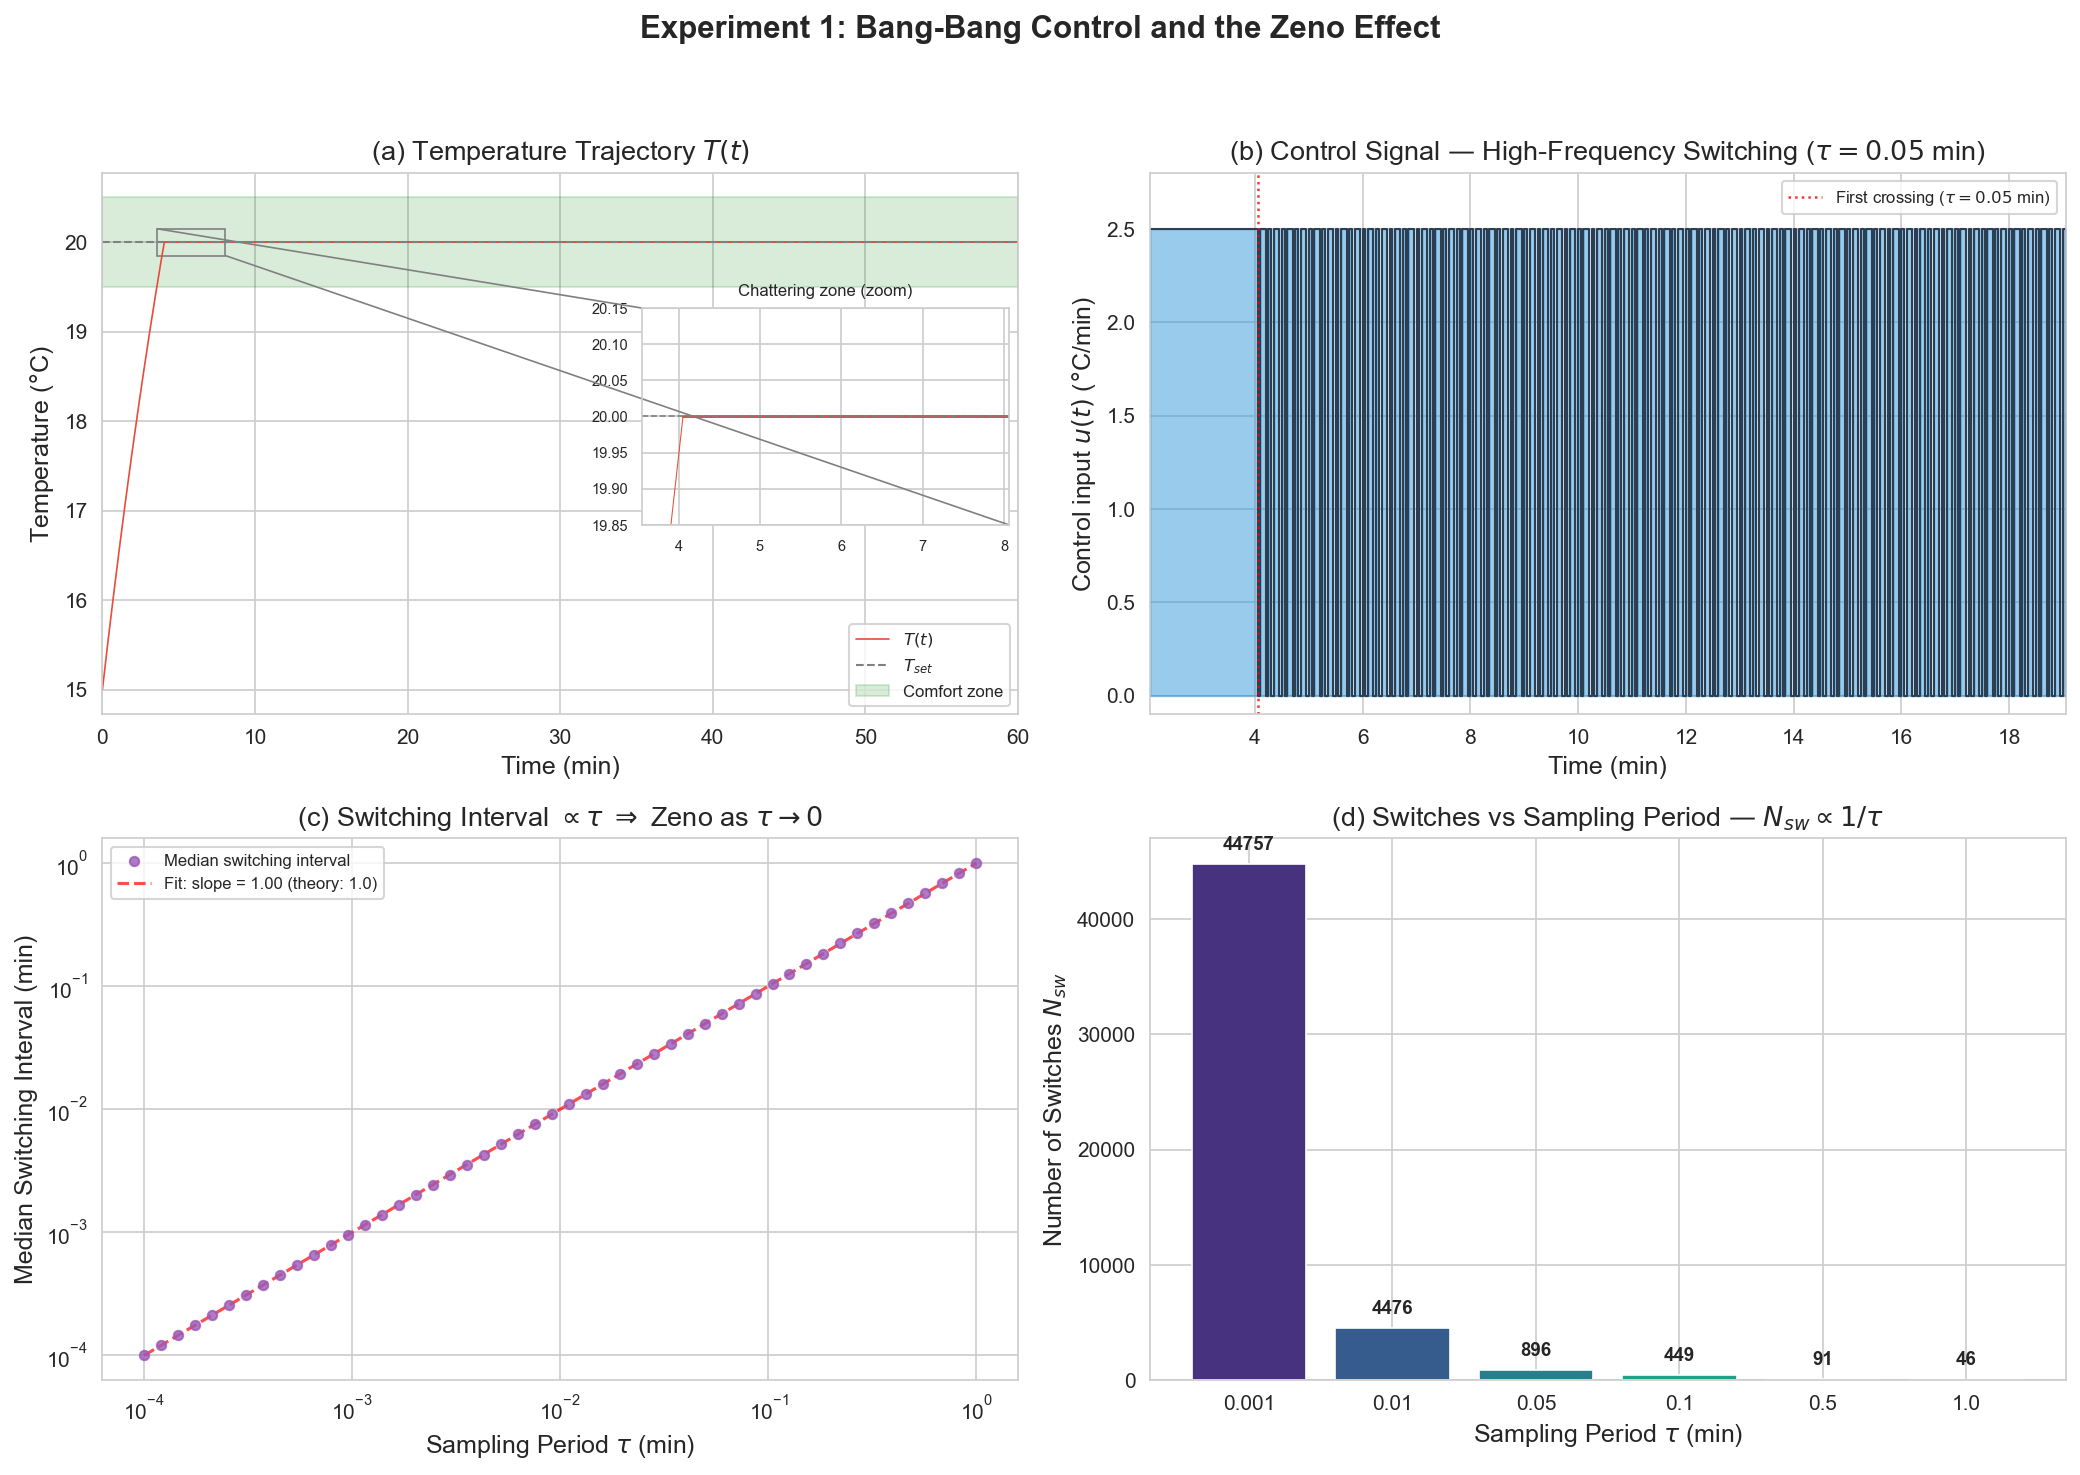

图 1 已保存。


In [7]:
# ============================================================
# 图 1：Zeno Effect 2×2 面板图
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Experiment 1: Bang-Bang Control and the Zeno Effect',
             fontsize=15, fontweight='bold', y=0.98)

# 找首次到达 T_set 的时刻（第一次 T >= T_set）
first_cross_idx = np.argmax(T_bb >= T_set)
t_cross = t_bb[first_cross_idx]
print(f'首次到达 T_set 的时刻: t = {t_cross:.3f} min')

# --- (a) 温度轨迹 + inset 放大 chattering ---
ax = axes[0, 0]
ax.plot(t_bb, T_bb, color='#e74c3c', linewidth=0.8, label='$T(t)$')
ax.axhline(T_set, color='gray', linestyle='--', linewidth=1, label='$T_{set}$')
ax.axhspan(T_set - 0.5, T_set + 0.5, alpha=0.15, color='green', label='Comfort zone')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Temperature ($°$C)')
ax.set_title('(a) Temperature Trajectory $T(t)$')
ax.legend(loc='lower right', fontsize=8)
ax.set_xlim(0, t_end)

# inset 放大 chattering 区域
inset_left = max(0, t_cross - 0.5)
inset_right = min(t_end, t_cross + 4)
axins = inset_axes(ax, width='40%', height='40%', loc='center right',
                   bbox_to_anchor=(0.0, 0.05, 1, 1), bbox_transform=ax.transAxes)
axins.plot(t_bb, T_bb, color='#e74c3c', linewidth=0.5)
axins.axhline(T_set, color='gray', linestyle='--', linewidth=0.8)
axins.set_xlim(inset_left, inset_right)
axins.set_ylim(T_set - 0.15, T_set + 0.15)
axins.set_title('Chattering zone (zoom)', fontsize=8)
axins.tick_params(labelsize=7)
mark_inset(ax, axins, loc1=2, loc2=4, fc='none', ec='0.5', lw=0.8)

# --- (b) 控制信号 u(t) — 两层缩放展示 ---
ax = axes[0, 1]
# 主图：用稍大的 dt 仿真来展示可见的脉冲（dt=0.05）
ctrl_bb_coarse = make_bangbang(T_set=T_set, U_max=U_max)
t_coarse, T_coarse, u_coarse = simulate_0d(ctrl_bb_coarse, dt=0.05, t_end=t_end)
first_cross_coarse = t_coarse[np.argmax(T_coarse >= T_set)]

zoom_left = max(0, first_cross_coarse - 2)
zoom_right = min(t_end, first_cross_coarse + 15)
mask_c = (t_coarse >= zoom_left) & (t_coarse <= zoom_right)
ax.fill_between(t_coarse[mask_c], 0, u_coarse[mask_c], alpha=0.5, color='#3498db', step='post')
ax.step(t_coarse[mask_c], u_coarse[mask_c], where='post', color='#2c3e50', linewidth=1.0)
ax.axvline(first_cross_coarse, color='red', linestyle=':', linewidth=1.2, alpha=0.8,
           label=f'First crossing ($\\tau=0.05$ min)')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Control input $u(t)$ ($°$C/min)')
ax.set_title('(b) Control Signal — High-Frequency Switching ($\\tau=0.05$ min)')
ax.set_xlim(zoom_left, zoom_right)
ax.set_ylim(-0.1, U_max + 0.3)
ax.legend(fontsize=8, loc='upper right')

# --- (c) 中位切换间隔 vs 采样步长 dt (log-log) ---
ax = axes[1, 0]
valid = ~np.isnan(avg_intervals)
ax.scatter(dt_values_for_analysis[valid], avg_intervals[valid],
           s=20, color='#9b59b6', alpha=0.8, zorder=3, label='Median switching interval')
valid_mask = valid & (avg_intervals > 0)
if np.sum(valid_mask) > 2:
    coeffs = np.polyfit(np.log10(dt_values_for_analysis[valid_mask]),
                        np.log10(avg_intervals[valid_mask]), 1)
    dt_fit = np.logspace(-4, 0, 100)
    interval_fit = 10**(coeffs[0] * np.log10(dt_fit) + coeffs[1])
    ax.plot(dt_fit, interval_fit, 'r--', linewidth=1.5, alpha=0.7,
            label=f'Fit: slope = {coeffs[0]:.2f} (theory: 1.0)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Sampling Period $\\tau$ (min)')
ax.set_ylabel('Median Switching Interval (min)')
ax.set_title('(c) Switching Interval $\\propto \\tau$ $\\Rightarrow$ Zeno as $\\tau \\to 0$')
ax.legend(fontsize=8)

# --- (d) 切换次数 vs 采样周期柱状图 ---
ax = axes[1, 1]
tau_labels = [f'{tau}' for tau in tau_values]
bars = ax.bar(tau_labels, tau_switch_counts,
              color=sns.color_palette('viridis', len(tau_values)),
              edgecolor='white', linewidth=0.8)
for bar, count in zip(bars, tau_switch_counts):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + max(tau_switch_counts)*0.02,
            str(count), ha='center', va='bottom', fontsize=9, fontweight='bold')
ax.set_xlabel('Sampling Period $\\tau$ (min)')
ax.set_ylabel('Number of Switches $N_{sw}$')
ax.set_title('(d) Switches vs Sampling Period — $N_{sw} \\propto 1/\\tau$')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f'{OUT_DIR}/0D_fig1_zeno_effect.png', dpi=300, bbox_inches='tight')
plt.show()
print('图 1 已保存。')

### 实验一结论

1. **(a)** 温度到达 $T_{set}$ 后在设定值附近剧烈振荡（chattering），放大图显示 ±0.01°C 级别的快速抖动
2. **(b)** 放大到切换区域后，可以看到控制信号在 0 和 $U_{\max}$ 之间高频交替
3. **(c)** 切换间隔与采样步长 $\tau$ 成正比（log-log 斜率 ≈ 1），证实 $\tau \to 0$ 时间隔趋零——即 Zeno 特征
4. **(d)** $\tau$ 每缩小 10 倍，切换次数增加约 10 倍，$N_{sw} \propto 1/\tau$

---

# 实验二：6 种控制策略对比

| 编号 | 策略 | 参数 |
|------|------|------|
| 1 | Bang-Bang | — |
| 2 | Hysteresis | $\delta = 0.5°C$ |
| 3 | P | $K_p = 2.0$ |
| 4 | PI | $K_p = 2.0, K_i = 0.5$ |
| 5 | PID | $K_p = 2.0, K_i = 0.5, K_d = 1.0$ |
| 6 | LQR | $Q = 100, R = 0.1$ |

**注意**：P 控制器存在稳态误差（$T_{ss} = \frac{k T_a + K_p T_{set}}{k + K_p} \approx 19.3°C$），无法精确跟踪 $T_{set}$。

In [8]:
# ============================================================
# 运行 6 种控制策略仿真
# ============================================================

dt_sim = 0.01  # 统一仿真步长

strategies = {
    'Bang-Bang':  make_bangbang(T_set=T_set, U_max=U_max),
    'Hysteresis': make_hysteresis(T_set=T_set, U_max=U_max, delta=0.5),
    'P':          make_P(T_set=T_set, U_max=U_max, Kp=2.0),
    'PI':         make_PI(T_set=T_set, U_max=U_max, Kp=2.0, Ki=0.5, dt=dt_sim),
    'PID':        make_PID(T_set=T_set, U_max=U_max, Kp=2.0, Ki=0.5, Kd=1.0, dt=dt_sim),
    'LQR':        make_LQR(T_set=T_set, T_a=T_a, U_max=U_max, k=k, Q=100.0, R_lqr=0.1),
}

results = {}
for name, ctrl in strategies.items():
    t_arr, T_arr, u_arr = simulate_0d(ctrl, dt=dt_sim, t_end=t_end)
    metrics = compute_metrics(t_arr, T_arr, u_arr, T_set=T_set, t_end=t_end, U_max=U_max)
    results[name] = {'t': t_arr, 'T': T_arr, 'u': u_arr, 'metrics': metrics}
    print(f'{name:12s} | E={metrics["E"]:.2f}  RMSE={metrics["RMSE"]:.3f}  '
          f'ΔTmax={metrics["DeltaT_max"]:.3f}  CR={metrics["CR"]:.3f}  '
          f't_s={metrics["t_s"]:.2f}  N_sw={metrics["N_sw"]}')

strategy_names = list(results.keys())
print('\n所有策略仿真完成。')

  LQR 增益 K = 31.5229, 稳态输入 u_ss = 1.50
Bang-Bang    | E=94.05  RMSE=0.714  ΔTmax=0.010  CR=0.963  t_s=3.57  N_sw=4476
Hysteresis   | E=93.93  RMSE=0.768  ΔTmax=0.508  CR=0.963  t_s=59.65  N_sw=66
P            | E=89.31  RMSE=0.996  ΔTmax=0.000  CR=0.963  t_s=60.00  N_sw=0
PI           | E=94.70  RMSE=0.768  ΔTmax=1.229  CR=0.963  t_s=9.65  N_sw=0
PID          | E=94.70  RMSE=0.769  ΔTmax=1.146  CR=0.963  t_s=10.11  N_sw=0
LQR          | E=94.05  RMSE=0.714  ΔTmax=0.000  CR=0.963  t_s=3.57  N_sw=0

所有策略仿真完成。


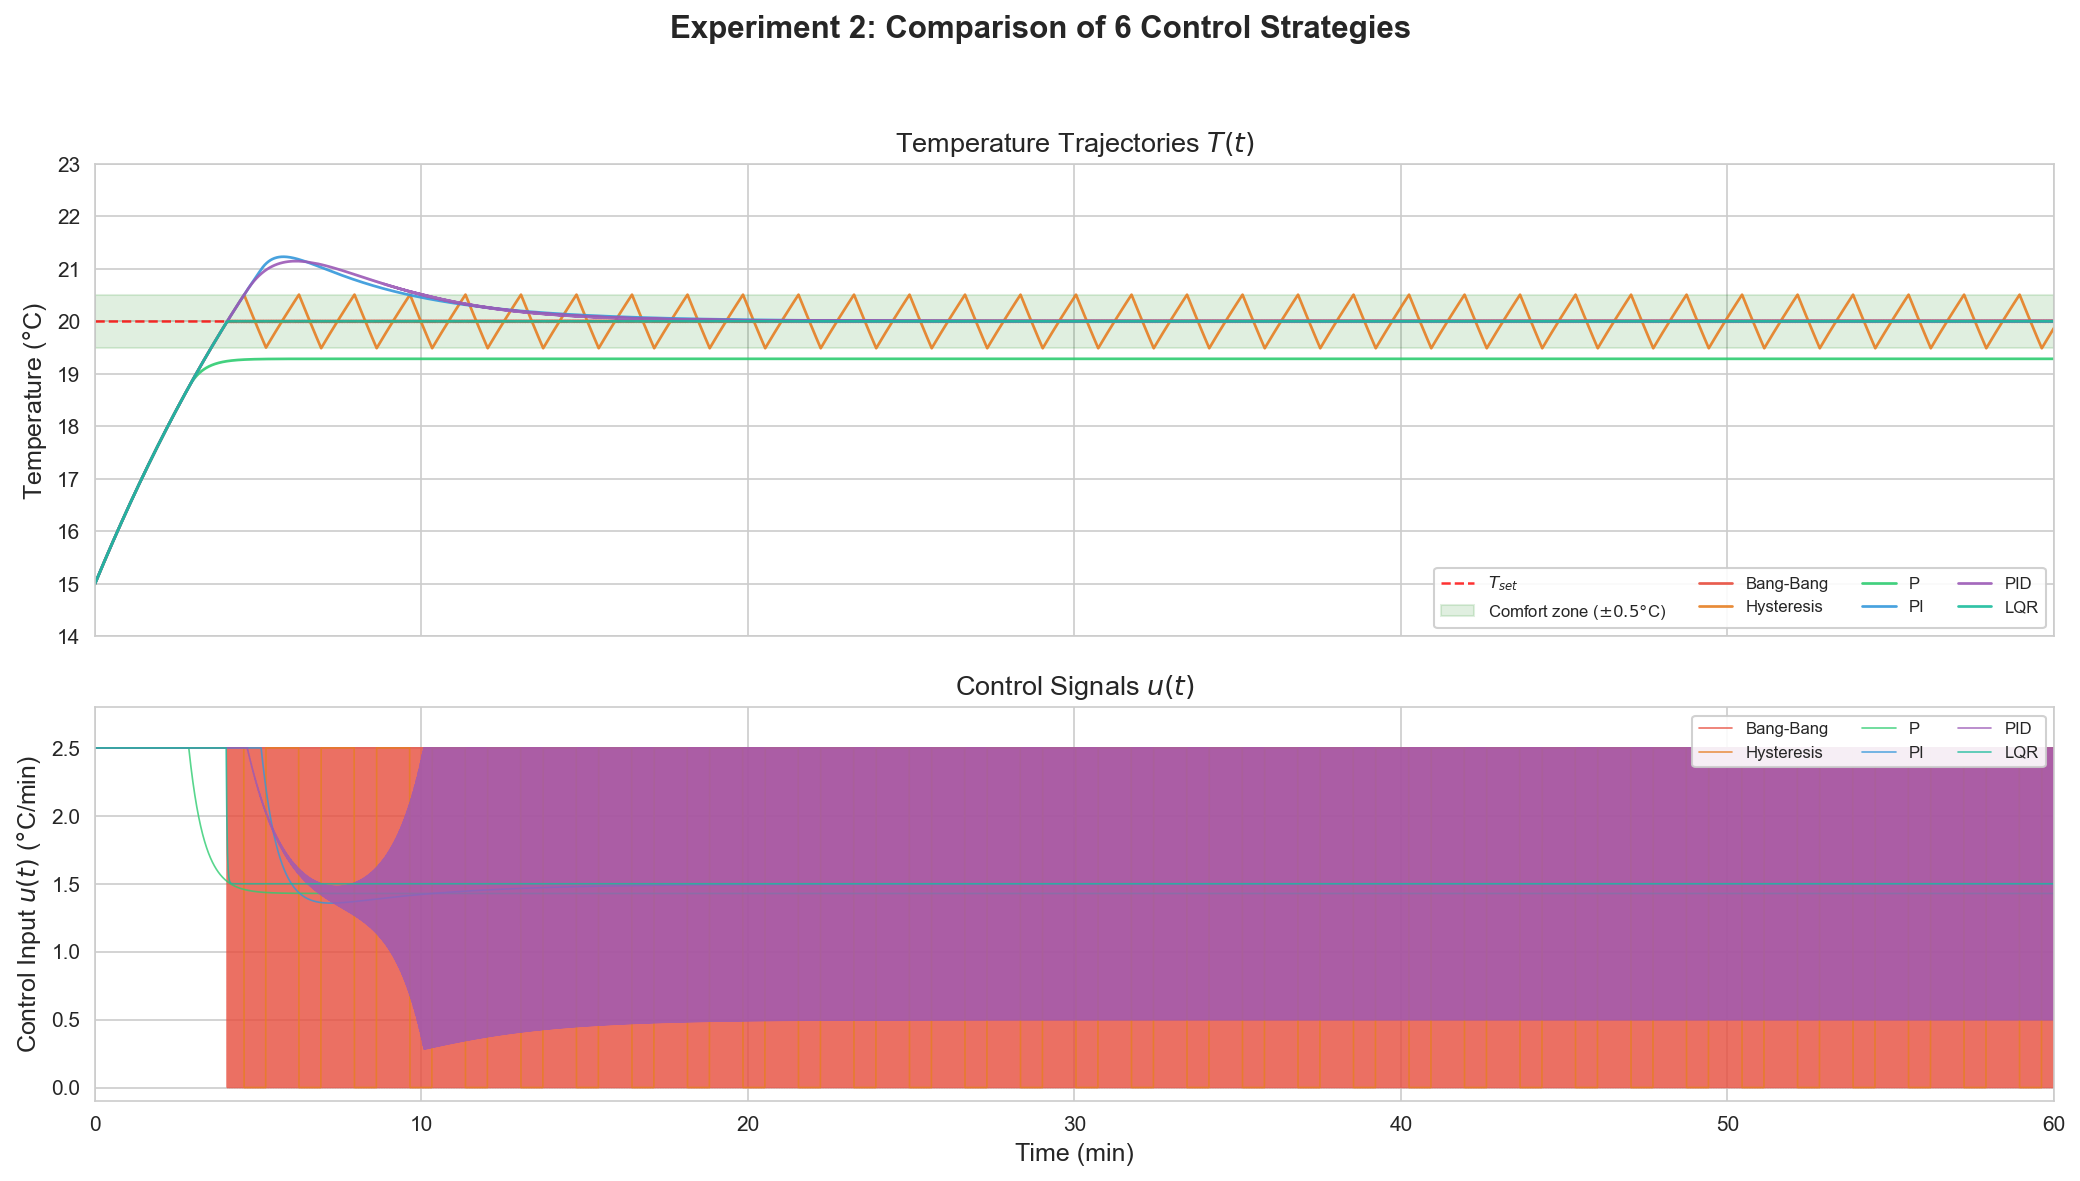

图 2 已保存。


In [9]:
# ============================================================
# 图 2：6 策略温度轨迹 + 控制信号对比图
# ============================================================

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8),
                                height_ratios=[1.2, 1], sharex=True)
fig.suptitle('Experiment 2: Comparison of 6 Control Strategies',
             fontsize=15, fontweight='bold', y=0.98)

# 上面板：温度轨迹
ax1.axhline(T_set, color='red', linestyle='--', linewidth=1.2, alpha=0.8, label='$T_{set}$')
ax1.axhspan(T_set - 0.5, T_set + 0.5, alpha=0.12, color='green',
            label='Comfort zone ($\\pm 0.5°$C)')

for name, res in results.items():
    ax1.plot(res['t'], res['T'], color=STRATEGY_COLORS[name],
             linewidth=1.3, label=name, alpha=0.9)

ax1.set_ylabel('Temperature ($°$C)')
ax1.set_title('Temperature Trajectories $T(t)$')
ax1.legend(loc='lower right', ncol=4, fontsize=8, framealpha=0.9)
ax1.set_ylim(T_init - 1, T_set + 3)

# 下面板：控制信号
for name, res in results.items():
    ax2.plot(res['t'], res['u'], color=STRATEGY_COLORS[name],
             linewidth=0.8, label=name, alpha=0.8)

ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Control Input $u(t)$ ($°$C/min)')
ax2.set_title('Control Signals $u(t)$')
ax2.legend(loc='upper right', ncol=3, fontsize=8, framealpha=0.9)
ax2.set_xlim(0, t_end)
ax2.set_ylim(-0.1, U_max + 0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f'{OUT_DIR}/0D_fig2_strategy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print('图 2 已保存。')

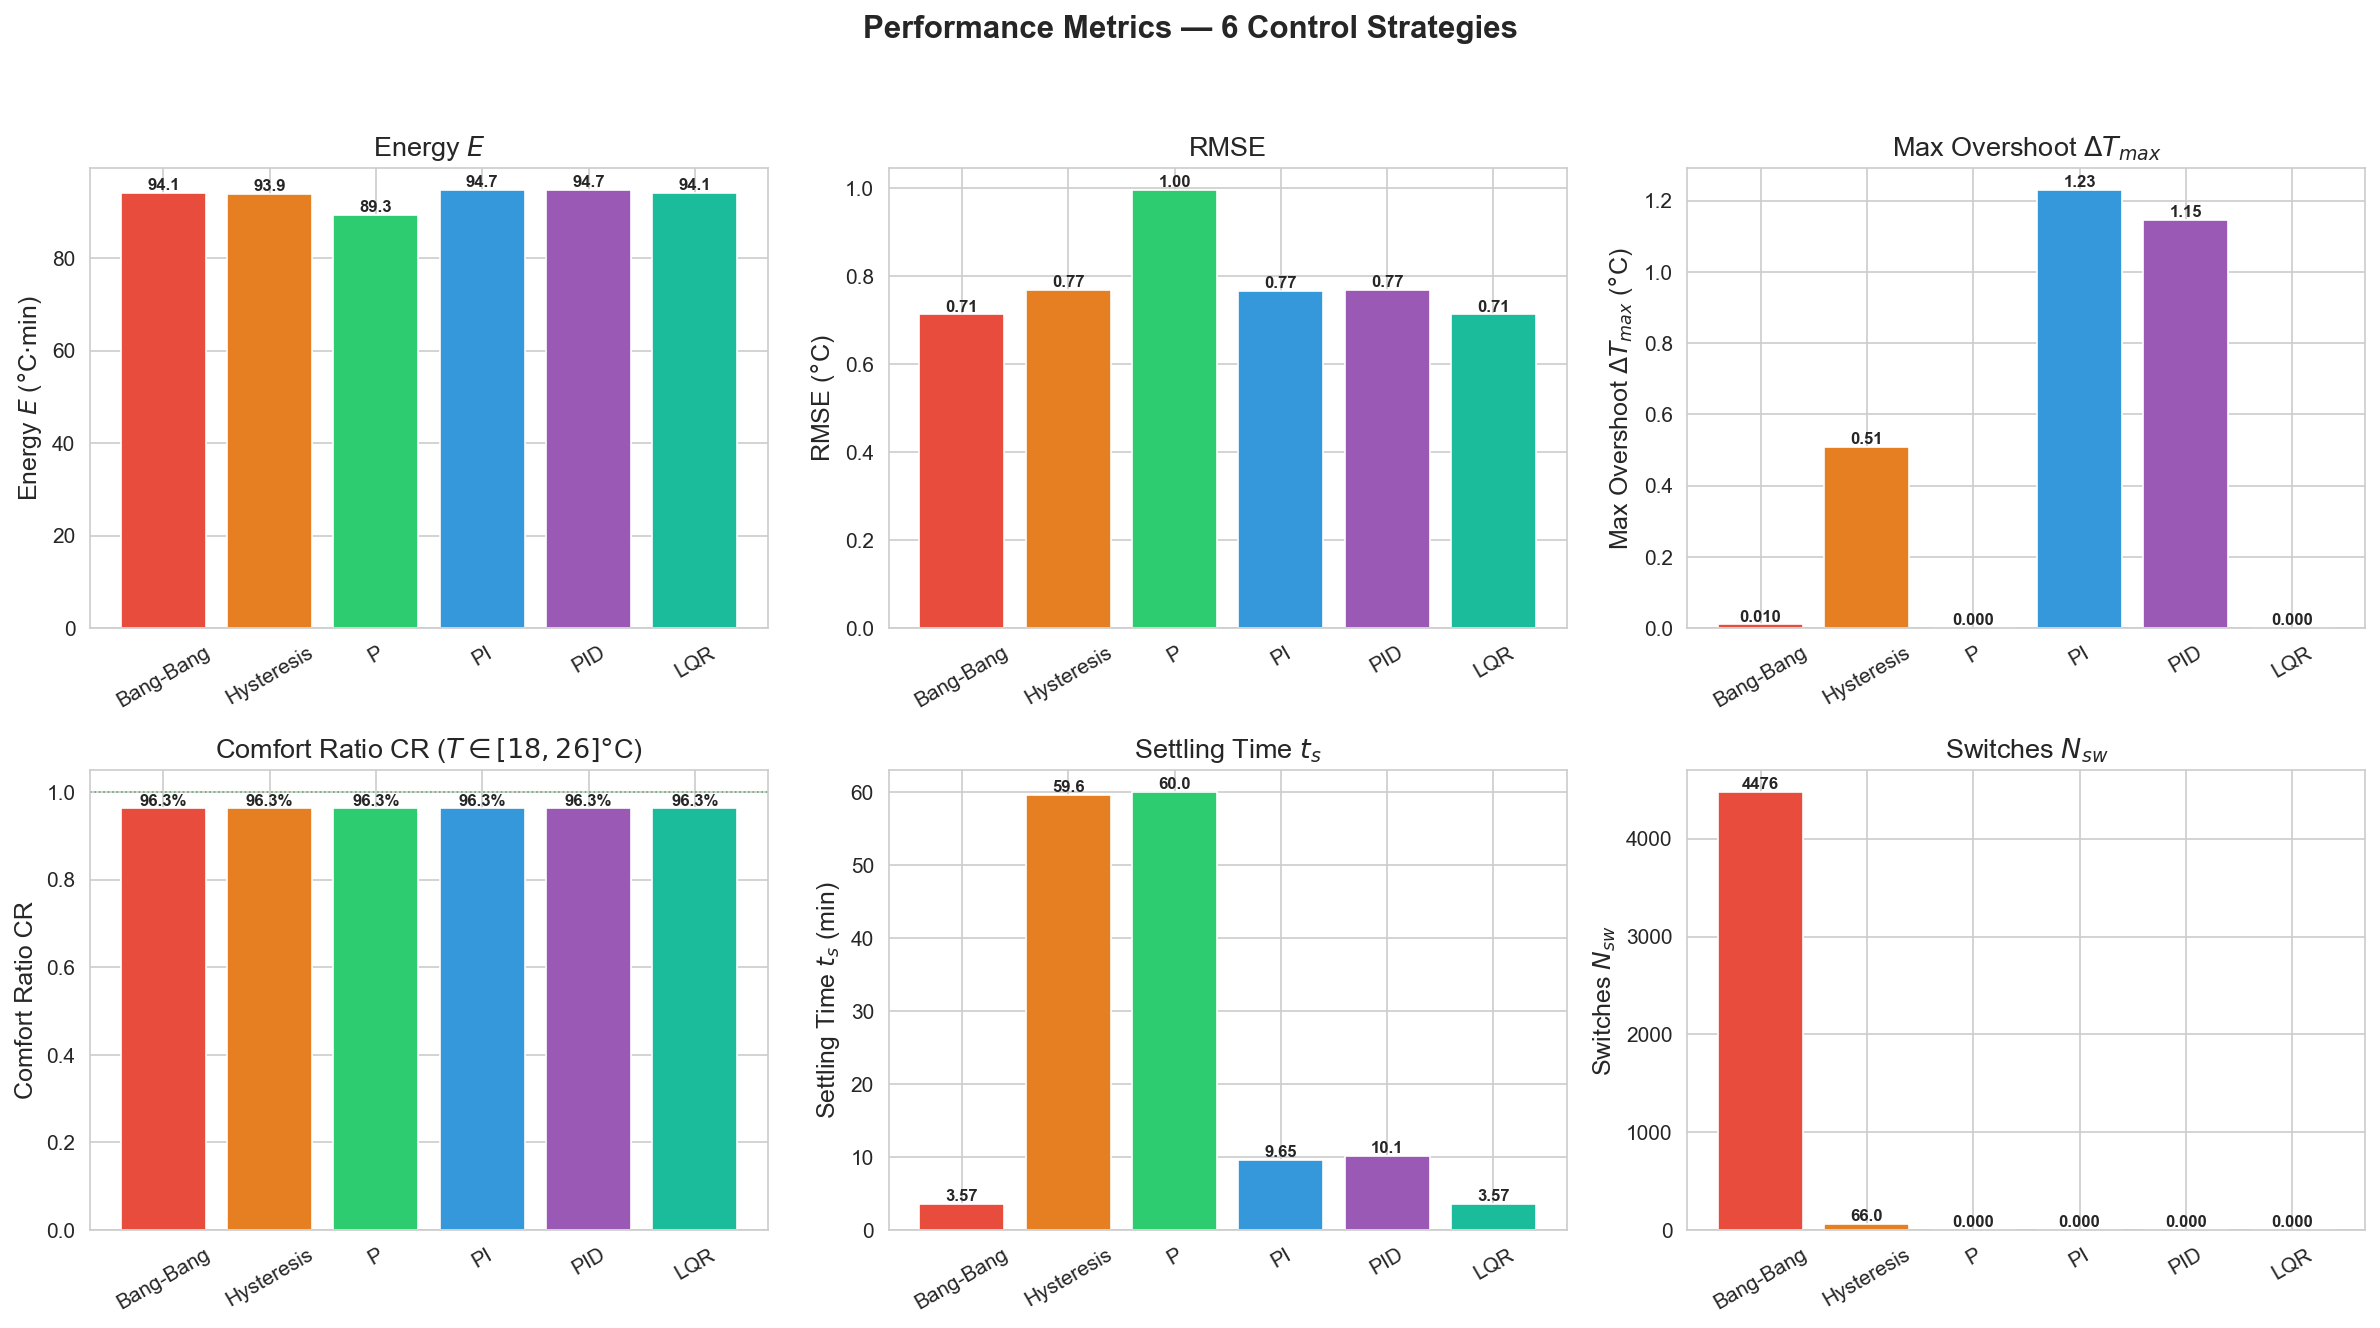

图 3 已保存。


In [10]:
# ============================================================
# 图 3：性能指标柱状图（2×3 面板，含 Comfort Ratio）
# ============================================================

metric_keys   = ['E', 'RMSE', 'DeltaT_max', 'CR', 't_s', 'N_sw']
metric_labels = [
    'Energy $E$ ($°$C$\\cdot$min)',
    'RMSE ($°$C)',
    'Max Overshoot $\\Delta T_{max}$ ($°$C)',
    'Comfort Ratio CR',
    'Settling Time $t_s$ (min)',
    'Switches $N_{sw}$',
]

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Performance Metrics — 6 Control Strategies',
             fontsize=15, fontweight='bold', y=0.98)

for idx, (mkey, mlabel) in enumerate(zip(metric_keys, metric_labels)):
    row, col = divmod(idx, 3)
    ax = axes[row, col]
    values = [results[s]['metrics'][mkey] for s in strategy_names]
    colors = [STRATEGY_COLORS[s] for s in strategy_names]

    bars = ax.bar(strategy_names, values, color=colors, edgecolor='white', linewidth=0.8)
    for bar, v in zip(bars, values):
        if mkey == 'CR':
            fmt = f'{v:.1%}'  # 百分比格式
        else:
            fmt = f'{v:.0f}' if v >= 100 else (f'{v:.1f}' if v >= 10 else (f'{v:.2f}' if v >= 0.1 else f'{v:.3f}'))
        ypos = bar.get_height() if bar.get_height() >= 0 else 0
        ax.text(bar.get_x() + bar.get_width()/2, ypos,
                fmt, ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax.set_ylabel(mlabel)
    ax.set_title(mlabel.split('(')[0].split('CR')[0].strip() if mkey != 'CR' else 'Comfort Ratio CR ($T \\in [18, 26]°$C)')
    ax.tick_params(axis='x', rotation=30)
    
    # CR 面板特殊处理：标绿色表示"越高越好"
    if mkey == 'CR':
        ax.set_ylim(0, 1.05)
        ax.axhline(1.0, color='green', linestyle=':', linewidth=0.8, alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f'{OUT_DIR}/0D_fig3_performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print('图 3 已保存。')

In [11]:
# ============================================================
# 统一代价 J 计算与数据表格
# ============================================================

# 参考量：各指标在 6 种策略中的最大值（保证归一化后 ∈ [0, 1]）
ref_maxes = {}
for mkey in ['E', 'RMSE', 'DeltaT_max', 'N_sw']:
    vals = [results[s]['metrics'][mkey] for s in strategy_names]
    ref_maxes[mkey] = max(vals) if max(vals) > 0 else 1.0

print('归一化参考量（同批次最大值）:')
for k_name, v in ref_maxes.items():
    print(f'  {k_name:12s} = {v:.4f}')

# 三种权重方案（含 w_C 权重，总和 = 1）
weight_schemes = {
    'Balanced': {'w_E': 0.15, 'w_R': 0.25, 'w_O': 0.15, 'w_C': 0.15, 'w_S': 0.15, 'w_T': 0.15},
    'Comfort':  {'w_E': 0.10, 'w_R': 0.25, 'w_O': 0.20, 'w_C': 0.20, 'w_S': 0.10, 'w_T': 0.15},
    'Energy':   {'w_E': 0.30, 'w_R': 0.20, 'w_O': 0.10, 'w_C': 0.10, 'w_S': 0.15, 'w_T': 0.15},
}

# 构建数据表
rows = []
for name in strategy_names:
    m = results[name]['metrics']
    row = {
        'Strategy': name,
        'Energy E': m['E'],
        'RMSE': m['RMSE'],
        'Max Overshoot': m['DeltaT_max'],
        'Comfort Ratio': m['CR'],
        'Settling Time': m['t_s'],
        'Switches': m['N_sw'],
        'Avg Temp (°C)': np.mean(results[name]['T']),
    }
    for wname, w in weight_schemes.items():
        row[f'J ({wname})'] = compute_unified_cost(m, ref_maxes, w, t_end=t_end)
    rows.append(row)

df = pd.DataFrame(rows)
df = df.sort_values('J (Balanced)').reset_index(drop=True)
df.index = df.index + 1
df.index.name = 'Rank'

print('\n=== 统一代价 J 与性能指标排名表 ===')
display(df.style.format({
    'Energy E': '{:.2f}', 'RMSE': '{:.4f}', 'Max Overshoot': '{:.4f}',
    'Comfort Ratio': '{:.1%}', 'Settling Time': '{:.2f}', 'Switches': '{:.0f}',
    'Avg Temp (°C)': '{:.2f}',
    'J (Balanced)': '{:.4f}', 'J (Comfort)': '{:.4f}', 'J (Energy)': '{:.4f}',
}).background_gradient(subset=['J (Balanced)'], cmap='RdYlGn_r')
 .background_gradient(subset=['Comfort Ratio'], cmap='RdYlGn')
 .background_gradient(subset=['RMSE'], cmap='RdYlGn_r')
 .background_gradient(subset=['Energy E'], cmap='RdYlGn_r'))

csv_path = f'{OUT_DIR}/0D_strategy_comparison.csv'
df.to_csv(csv_path)
print(f'\n数据已保存至 {csv_path}')

归一化参考量（同批次最大值）:
  E            = 94.7029
  RMSE         = 0.9962
  DeltaT_max   = 1.2295
  N_sw         = 4476.0000

=== 统一代价 J 与性能指标排名表 ===


,Strategy,Energy E,RMSE,Max Overshoot,Comfort Ratio,Settling Time,Switches,Avg Temp (°C),J (Balanced),J (Comfort),J (Energy)
Rank,,,,,,,,,,,
1,LQR,94.05,0.7139,0.0000,96.3%,3.57,0,19.84,0.3426,0.2948,0.4539
2,Bang-Bang,94.05,0.7139,0.0100,96.3%,3.57,4476,19.84,0.4939,0.3965,0.6047
3,PID,94.70,0.7693,1.1459,96.3%,10.11,0,19.95,0.5137,0.5122,0.5767
4,PI,94.70,0.7678,1.2295,96.3%,9.65,0,19.95,0.5224,0.5243,0.5820
5,P,89.31,0.9962,0.0000,96.3%,60.00,0,19.17,0.5471,0.5018,0.6366
6,Hysteresis,93.93,0.7685,0.5085,96.3%,59.65,66,19.84,0.5606,0.5328,0.6482



数据已保存至 0D_output/0D_strategy_comparison.csv


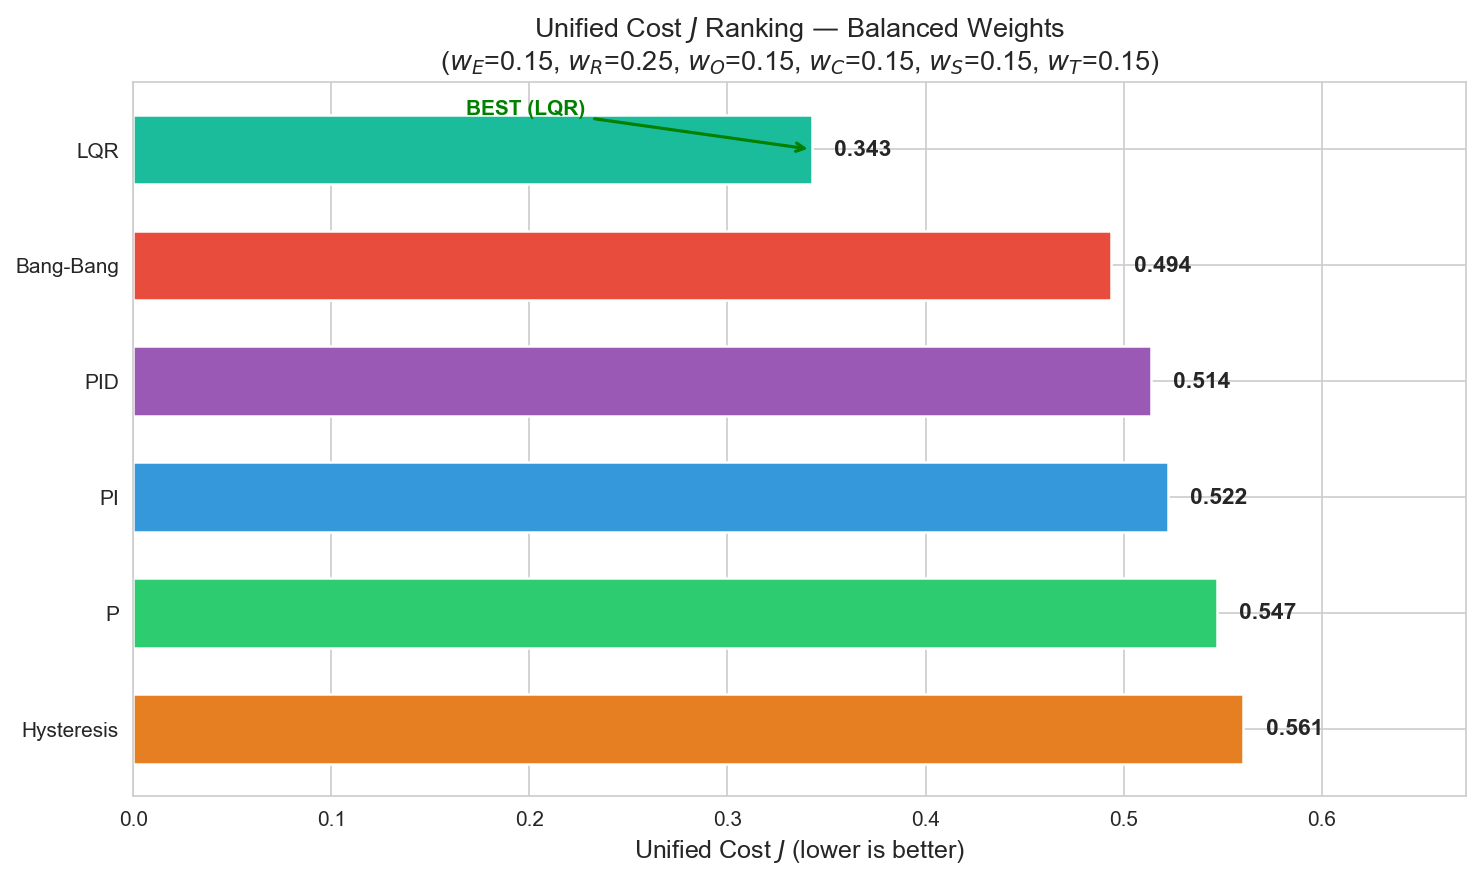

图 4 已保存。


In [12]:
# ============================================================
# 图 4：统一代价 J 柱状图（按排名排序）
# ============================================================

fig, ax = plt.subplots(figsize=(10, 6))

j_balanced = {name: compute_unified_cost(results[name]['metrics'], ref_maxes,
              weight_schemes['Balanced'], t_end=t_end) for name in strategy_names}
sorted_strats = sorted(j_balanced.keys(), key=lambda x: j_balanced[x])
j_vals = [j_balanced[s] for s in sorted_strats]
colors = [STRATEGY_COLORS[s] for s in sorted_strats]

bars = ax.barh(sorted_strats, j_vals, color=colors, edgecolor='white', linewidth=1.2, height=0.6)

for bar, v in zip(bars, j_vals):
    ax.text(v + max(j_vals)*0.02, bar.get_y() + bar.get_height()/2,
            f'{v:.3f}', va='center', ha='left', fontsize=11, fontweight='bold')

ax.set_xlabel('Unified Cost $J$ (lower is better)', fontsize=12)
ax.set_title('Unified Cost $J$ Ranking — Balanced Weights\n'
             '($w_E$=0.15, $w_R$=0.25, $w_O$=0.15, $w_C$=0.15, $w_S$=0.15, $w_T$=0.15)',
             fontsize=13)
ax.invert_yaxis()
ax.set_xlim(0, max(j_vals) * 1.2)

best_name = sorted_strats[0]
ax.annotate(f'BEST ({best_name})',
            xy=(j_vals[0], 0), fontsize=10, fontweight='bold', color='green',
            xytext=(max(j_vals)*0.3, -0.3),
            arrowprops=dict(arrowstyle='->', color='green', lw=1.5))

plt.tight_layout()
plt.savefig(f'{OUT_DIR}/0D_fig4_unified_cost_ranking.png', dpi=300, bbox_inches='tight')
plt.show()
print('图 4 已保存。')

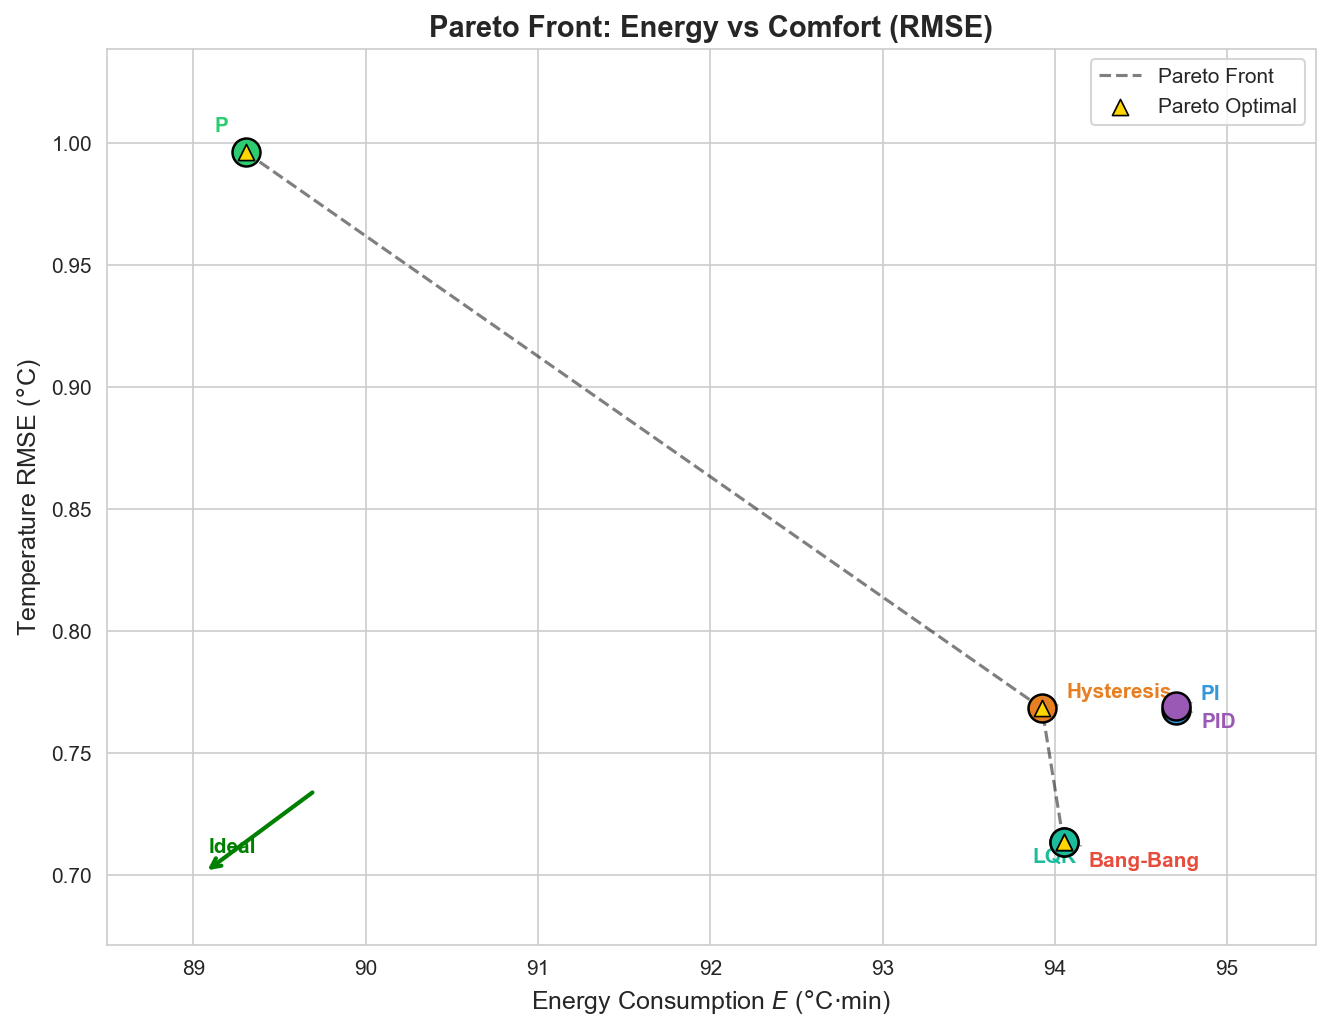

Pareto 最优策略:
  P: E=89.31, RMSE=0.9962
  Hysteresis: E=93.93, RMSE=0.7685
  Bang-Bang: E=94.05, RMSE=0.7139
  LQR: E=94.05, RMSE=0.7139


In [13]:
# ============================================================
# 图 5：Pareto 前沿散点图（能耗 E vs RMSE）
# ============================================================

fig, ax = plt.subplots(figsize=(9, 7))

E_vals = [results[s]['metrics']['E'] for s in strategy_names]
RMSE_vals = [results[s]['metrics']['RMSE'] for s in strategy_names]

# 绘制散点
for i, name in enumerate(strategy_names):
    ax.scatter(E_vals[i], RMSE_vals[i],
              color=STRATEGY_COLORS[name], s=180, zorder=5,
              edgecolors='black', linewidth=1.2)

# 标注策略名（偏移量手动调整避免重叠）
offsets = {
    'Bang-Bang': (12, -12), 'Hysteresis': (12, 5),
    'P': (-15, 10), 'PI': (12, 5),
    'PID': (12, -10), 'LQR': (-15, -10),
}
for i, name in enumerate(strategy_names):
    ox, oy = offsets.get(name, (10, 5))
    ax.annotate(name, (E_vals[i], RMSE_vals[i]),
                textcoords='offset points', xytext=(ox, oy),
                fontsize=10, fontweight='bold', color=STRATEGY_COLORS[name],
                arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, shrinkB=5))

# 计算 Pareto 前沿
points = list(zip(E_vals, RMSE_vals, strategy_names))
pareto = []
for e, r, n in points:
    dominated = any((e2 <= e and r2 <= r) and (e2 < e or r2 < r)
                    for e2, r2, n2 in points)
    if not dominated:
        pareto.append((e, r, n))

pareto.sort(key=lambda x: x[0])
if len(pareto) > 1:
    pe = [p[0] for p in pareto]
    pr = [p[1] for p in pareto]
    ax.plot(pe, pr, 'k--', linewidth=1.5, alpha=0.5, label='Pareto Front')
    ax.scatter(pe, pr, marker='^', s=60, color='gold',
               edgecolors='black', linewidth=0.8, zorder=6, label='Pareto Optimal')

# 坐标范围适配数据
e_margin = (max(E_vals) - min(E_vals)) * 0.15
r_margin = (max(RMSE_vals) - min(RMSE_vals)) * 0.15
ax.set_xlim(min(E_vals) - e_margin, max(E_vals) + e_margin)
ax.set_ylim(min(RMSE_vals) - r_margin, max(RMSE_vals) + r_margin)

# 优化方向箭头
ax.annotate('', xy=(min(E_vals) - e_margin*0.3, min(RMSE_vals) - r_margin*0.3),
            xytext=(min(E_vals) + e_margin*0.5, min(RMSE_vals) + r_margin*0.5),
            arrowprops=dict(arrowstyle='->', color='green', lw=2))
ax.text(min(E_vals) - e_margin*0.1, min(RMSE_vals) - r_margin*0.1,
        'Ideal', fontsize=10, color='green', ha='center', fontweight='bold')

ax.set_xlabel('Energy Consumption $E$ ($°$C$\\cdot$min)', fontsize=12)
ax.set_ylabel('Temperature RMSE ($°$C)', fontsize=12)
ax.set_title('Pareto Front: Energy vs Comfort (RMSE)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.savefig(f'{OUT_DIR}/0D_fig5_pareto_front.png', dpi=300, bbox_inches='tight')
plt.show()

print('Pareto 最优策略:')
for e, r, n in pareto:
    print(f'  {n}: E={e:.2f}, RMSE={r:.4f}')

---

## 三种权重方案下的排名对比

为验证排名的鲁棒性，分别使用 **平衡型**、**舒适优先** 和 **节能优先** 三种权重方案计算统一代价 $J$。

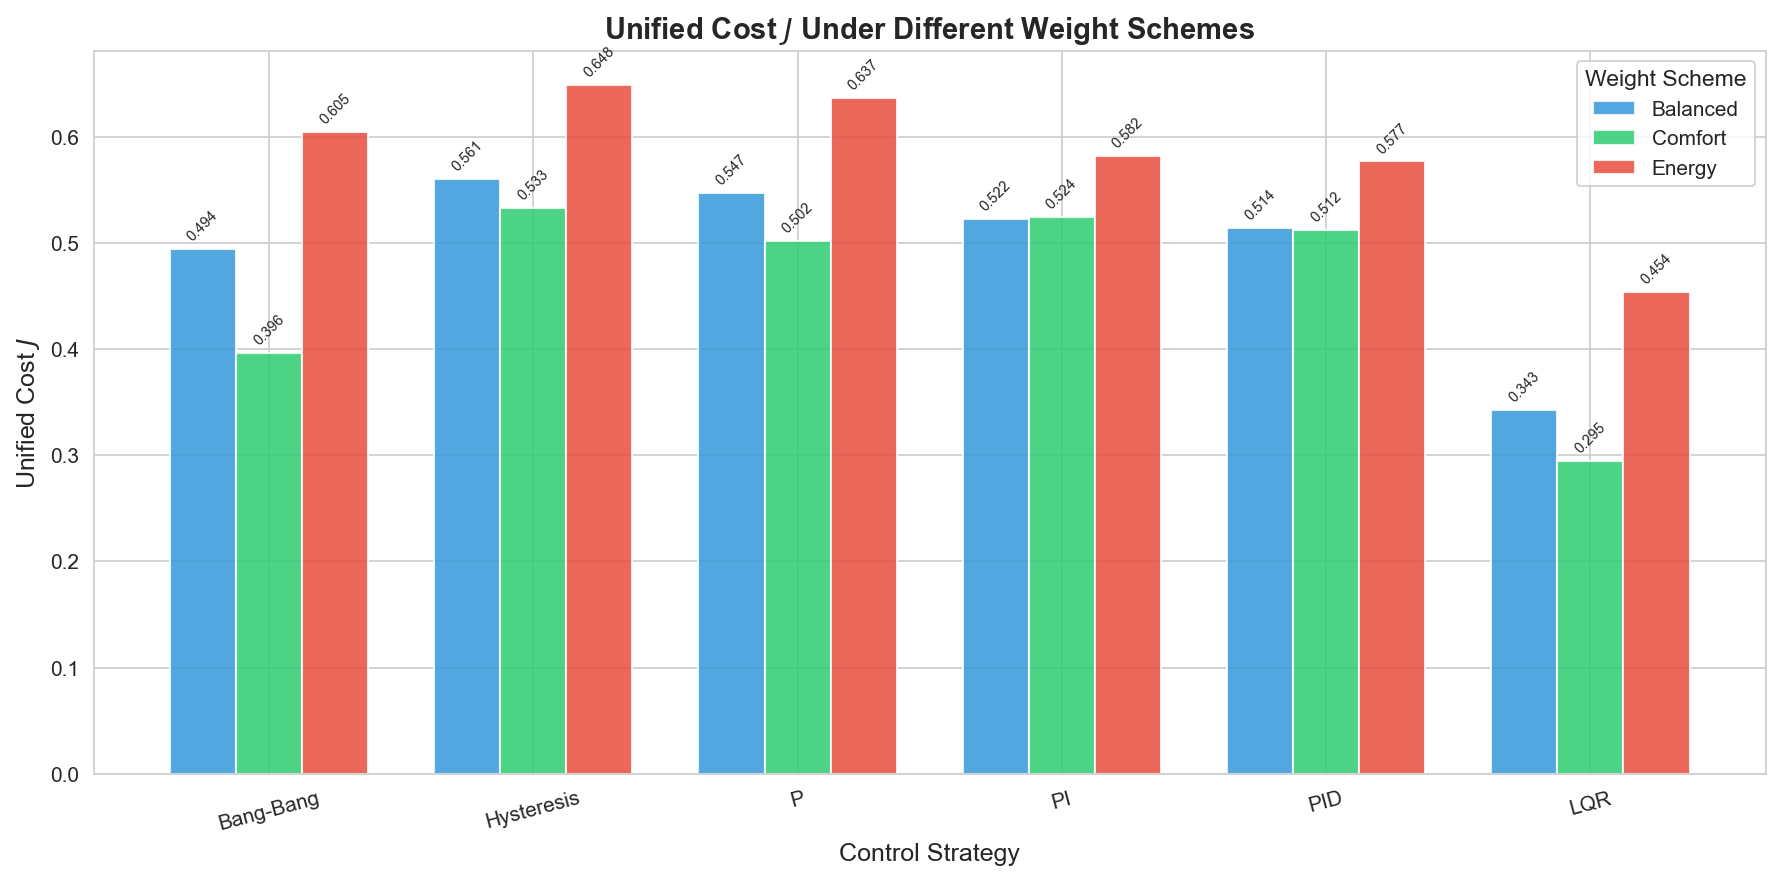

图 6 已保存。


In [14]:
# ============================================================
# 图 6：三种权重方案下的 J 对比分组柱状图
# ============================================================

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(strategy_names))
width = 0.25
scheme_colors = ['#3498db', '#2ecc71', '#e74c3c']

for i, (wname, w) in enumerate(weight_schemes.items()):
    j_vals = [compute_unified_cost(results[s]['metrics'], ref_maxes, w, t_end=t_end)
              for s in strategy_names]
    bars = ax.bar(x + i * width, j_vals, width, label=wname,
                  color=scheme_colors[i], alpha=0.85, edgecolor='white')
    for bar, v in zip(bars, j_vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{v:.3f}', ha='center', va='bottom', fontsize=7, rotation=45)

ax.set_xlabel('Control Strategy', fontsize=12)
ax.set_ylabel('Unified Cost $J$', fontsize=12)
ax.set_title('Unified Cost $J$ Under Different Weight Schemes', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(strategy_names, rotation=15)
ax.legend(title='Weight Scheme', fontsize=10)

plt.tight_layout()
plt.savefig(f'{OUT_DIR}/0D_fig6_weight_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print('图 6 已保存。')

---

## 总结

### 实验一：Zeno Effect

- Bang-Bang 控制器在连续时间极限下出现 **Zeno 现象**：切换间隔 $\Delta t \propto \tau$，切换次数 $N_{sw} \propto 1/\tau$
- 实际工程中需要引入 **迟滞带**（Hysteresis）或 **最小开关时间** 来避免无穷频繁切换

### 实验二：6 种策略对比

基于统一代价函数 $J$ 的综合评价：

1. **LQR** 在综合评价中表现最优——零切换、快速稳定、精确跟踪
2. **PI/PID** 有积分项消除稳态误差，但存在一定超调
3. **P 控制器** 无超调但存在固有稳态误差（$\approx 0.7°C$），RMSE 最高
4. **Bang-Bang** 升温最快但切换次数极高（Zeno 效应），设备磨损严重
5. **Hysteresis** 大幅削减切换次数，但温度在 $\pm\delta$ 带内振荡，稳定时间长
6. **Pareto 分析** 揭示能耗-舒适度之间的权衡——无策略能同时最优化两者

### 下一步

本 0D 分析为后续 **1D** 和 **2D** 仿真提供了基线数据和评价框架。在更高维模型中，控制策略将结合加热器/恒温器位置、边界条件进行联合优化。